<a href="https://colab.research.google.com/github/huggingface/deep-rl-class/blob/ThomasSimonini%2FPG/notebooks/unit4/unit4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 4: Code your first Deep Reinforcement Learning Algorithm with PyTorch: Reinforce. And test its robustness 💪

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/thumbnail.png" alt="thumbnail"/>


In this notebook, you'll code your first Deep Reinforcement Learning algorithm from scratch: Reinforce (also called Monte Carlo Policy Gradient).

Reinforce is a *Policy-based method*: a Deep Reinforcement Learning algorithm that tries **to optimize the policy directly without using an action-value function**.

More precisely, Reinforce is a *Policy-gradient method*, a subclass of *Policy-based methods* that aims **to optimize the policy directly by estimating the weights of the optimal policy using gradient ascent**.

To test its robustness, we're going to train it in 2 different simple environments:
- Cartpole-v1
- PixelcopterEnv

⬇️ Here is an example of what **you will achieve at the end of this notebook.** ⬇️

  <img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/envs.gif" alt="Environments"/>


###🎮 Environments: 

- [CartPole-v1](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)
- [PixelCopter](https://pygame-learning-environment.readthedocs.io/en/latest/user/games/pixelcopter.html)

###📚 RL-Library: 

- Python
- PyTorch


We're constantly trying to improve our tutorials, so **if you find some issues in this notebook**, please [open an issue on the GitHub Repo](https://github.com/huggingface/deep-rl-class/issues).

## Objectives of this notebook 🏆
At the end of the notebook, you will:
- Be able to **code from scratch a Reinforce algorithm using PyTorch.**
- Be able to **test the robustness of your agent using simple environments.**
- Be able to **push your trained agent to the Hub** with a nice video replay and an evaluation score 🔥.

## This notebook is from the Deep Reinforcement Learning Course
<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/deep-rl-course-illustration.jpg" alt="Deep RL Course illustration"/>

In this free course, you will:

- 📖 Study Deep Reinforcement Learning in **theory and practice**.
- 🧑‍💻 Learn to **use famous Deep RL libraries** such as Stable Baselines3, RL Baselines3 Zoo, CleanRL and Sample Factory 2.0.
- 🤖 Train **agents in unique environments** 

And more check 📚 the syllabus 👉 https://simoninithomas.github.io/deep-rl-course

Don’t forget to **<a href="http://eepurl.com/ic5ZUD">sign up to the course</a>** (we are collecting your email to be able to **send you the links when each Unit is published and give you information about the challenges and updates).**


The best way to keep in touch is to join our discord server to exchange with the community and with us 👉🏻 https://discord.gg/ydHrjt3WP5

## Prerequisites 🏗️
Before diving into the notebook, you need to:

🔲 📚 [Study Policy Gradients by reading Unit 4](https://huggingface.co/deep-rl-course/unit4/introduction)

# Let's code Reinforce algorithm from scratch 🔥


To validate this hands-on for the certification process, you need to push your trained models to the Hub.

- Get a result of >= 350 for `Cartpole-v1`.
- Get a result of >= 5 for `PixelCopter`.

To find your result, go to the leaderboard and find your model, **the result = mean_reward - std of reward**. **If you don't see your model on the leaderboard, go at the bottom of the leaderboard page and click on the refresh button**.

For more information about the certification process, check this section 👉 https://huggingface.co/deep-rl-course/en/unit0/introduction#certification-process


## An advice 💡
It's better to run this colab in a copy on your Google Drive, so that **if it timeouts** you still have the saved notebook on your Google Drive and do not need to fill everything from scratch.

To do that you can either do `Ctrl + S` or `File > Save a copy in Google Drive.`

## Set the GPU 💪
- To **accelerate the agent's training, we'll use a GPU**. To do that, go to `Runtime > Change Runtime type`

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/gpu-step1.jpg" alt="GPU Step 1">

- `Hardware Accelerator > GPU`

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/gpu-step2.jpg" alt="GPU Step 2">

## Create a virtual display 🖥

During the notebook, we'll need to generate a replay video. To do so, with colab, **we need to have a virtual screen to be able to render the environment** (and thus record the frames). 

Hence the following cell will install the librairies and create and run a virtual screen 🖥

In [ ]:
%%capture
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip install pyvirtualdisplay
!pip install pyglet==1.5.1

In [ ]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

## Install the dependencies 🔽
The first step is to install the dependencies, we’ll install multiple ones:

- `gym`
- `gym-games`: Extra gym environments made with PyGame.
- `huggingface_hub`: 🤗 works as a central place where anyone can share and explore models and datasets. It has versioning, metrics, visualizations and other features that will allow you to easily collaborate with others.

You can see here all the Reinforce models available 👉 https://huggingface.co/models?other=reinforce

And you can find all the Deep Reinforcement Learning models here 👉 https://huggingface.co/models?pipeline_tag=reinforcement-learning


In [ ]:
!pip install -r https://huggingface.co/spaces/ThomasSimonini/temp-space-requirements/resolve/main/requirements/requirements-unit4.txt

In [ ]:
# TODO UNCOMMENT BEFORE MERGING
# !pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit4/requirements-unit4.txt

## Import the packages 📦
In addition to import the installed libraries, we also import:

- `imageio`: A library that will help us to generate a replay video



In [ ]:
import numpy as np

from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gym
import gym_pygame

# Hugging Face Hub
from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.
import imageio

## Check if we have a GPU

- Let's check if we have a GPU
- If it's the case you should see `device:cuda0`

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

We're now ready to implement our Reinforce algorithm 🔥

# First agent: Playing CartPole-v1 🤖

## Create the CartPole environment and understand how it works
### [The environment 🎮](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)


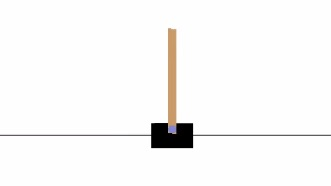

### Why do we use a simple environment like CartPole-v1?
As explained in [Reinforcement Learning Tips and Tricks](https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html), when you implement your agent from scratch you need **to be sure that it works correctly and find bugs with easy environments before going deeper**. Since finding bugs will be much easier in simple environments.


> Try to have some “sign of life” on toy problems


> Validate the implementation by making it run on harder and harder envs (you can compare results against the RL zoo). You usually need to run hyperparameter optimization for that step.
___
### The CartPole-v1 environment

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.



So, we start with CartPole-v1. The goal is to push the cart left or right **so that the pole stays in the equilibrium.**

The episode ends if:
- The pole Angle is greater than ±12°
- Cart Position is greater than ±2.4
- Episode length is greater than 500

We get a reward 💰 of +1 every timestep the Pole stays in the equilibrium.

In [ ]:
env_id = "CartPole-v1"
# Create the env
env = gym.make(env_id)

# Create the evaluation env
eval_env = gym.make(env_id)

# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

In [ ]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action

## Let's build the Reinforce Architecture
This implementation is based on two implementations:
- [PyTorch official Reinforcement Learning example](https://github.com/pytorch/examples/blob/main/reinforcement_learning/reinforce.py)
- [Udacity Reinforce](https://github.com/udacity/deep-reinforcement-learning/blob/master/reinforce/REINFORCE.ipynb)
- [Improvement of the integration by Chris1nexus](https://github.com/huggingface/deep-rl-class/pull/95)

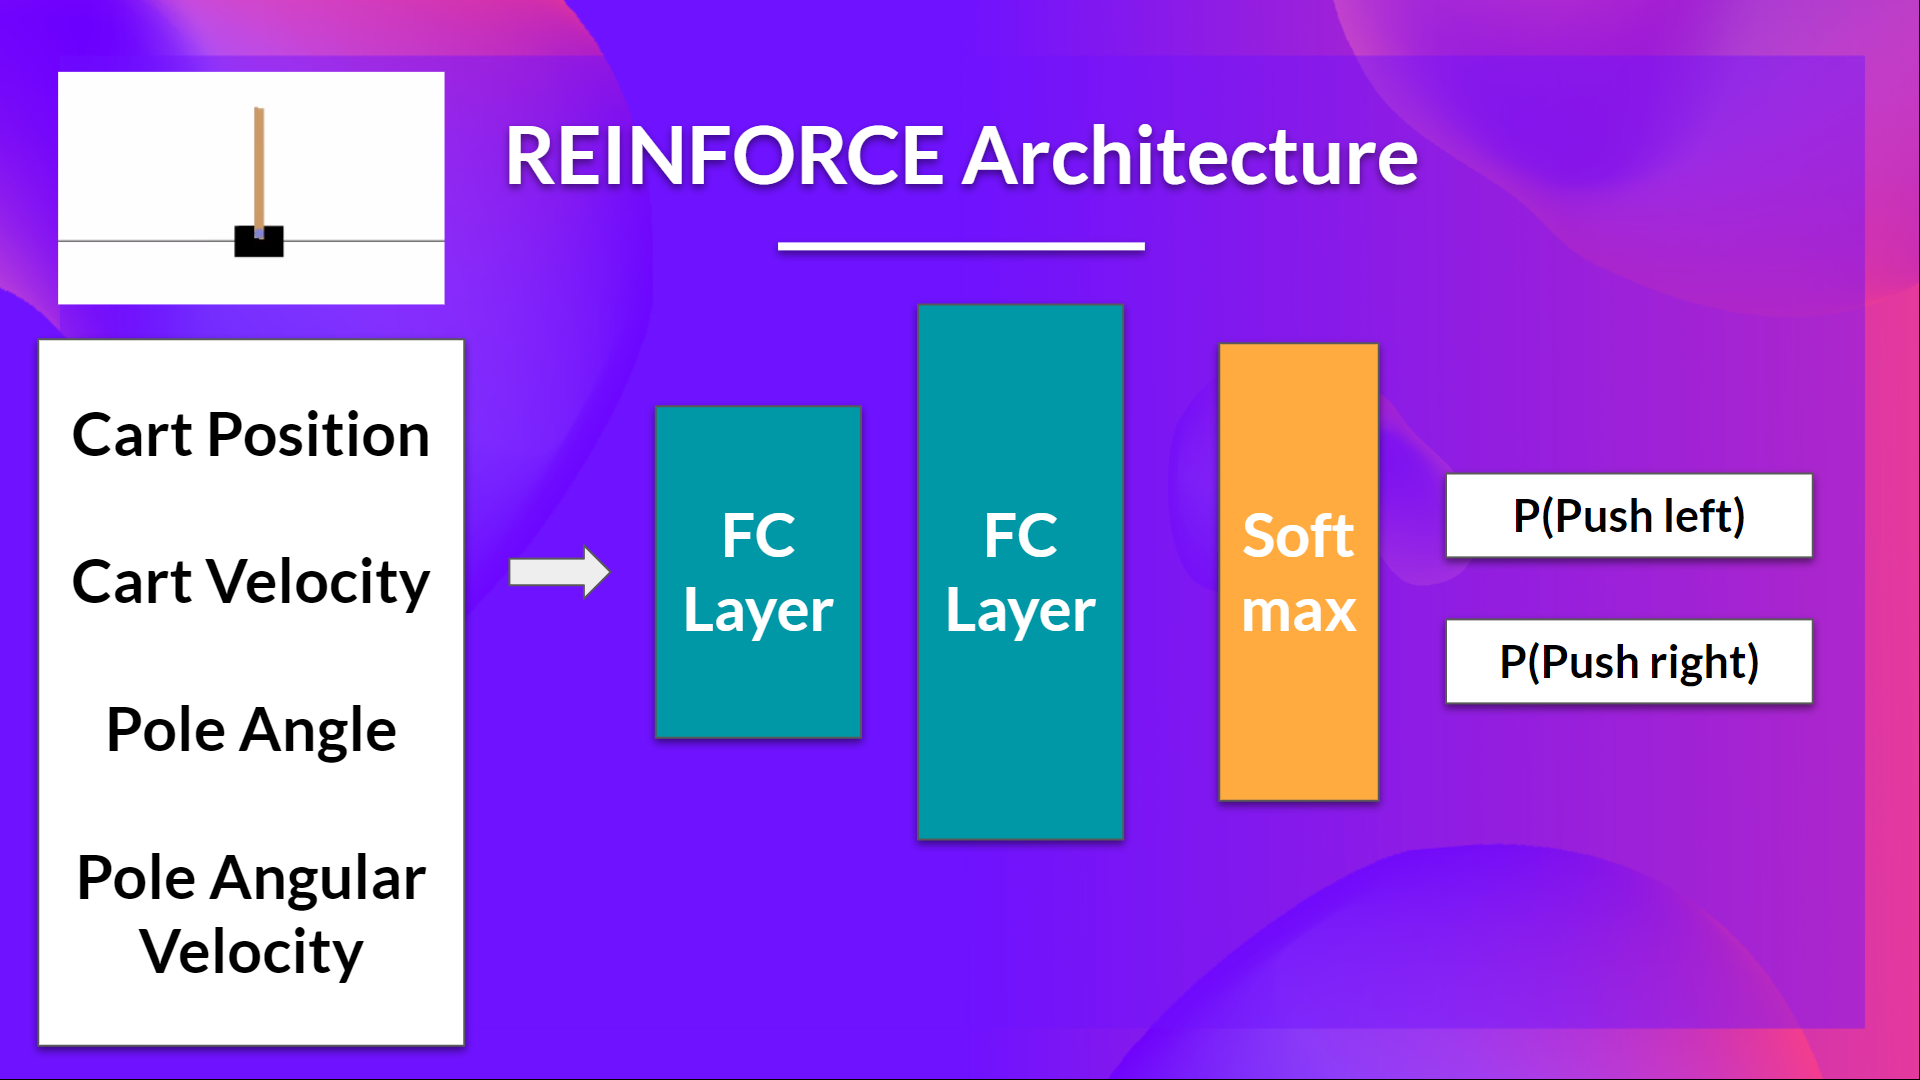

So we want:
- Two fully connected layers (fc1 and fc2).
- Using ReLU as activation function of fc1
- Using Softmax to output a probability distribution over actions

In [ ]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        # Create two fully connected layers



    def forward(self, x):
        # Define the forward pass
        # state goes to fc1 then we apply ReLU activation function

        # fc1 outputs goes to fc2

        # We output the softmax
    
    def act(self, state):
        """
        Given a state, take action
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = np.argmax(m)
        return action.item(), m.log_prob(action)

### Solution

In [ ]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = np.argmax(m)
        return action.item(), m.log_prob(action)

I make a mistake, can you guess where?

- To find out let's make a forward pass:

In [ ]:
debug_policy = Policy(s_size, a_size, 64).to(device)
debug_policy.act(env.reset())

- Here we see that the error says `ValueError: The value argument to log_prob must be a Tensor`

- It means that `action` in `m.log_prob(action)` must be a Tensor **but it's not.**

- Do you know why? Check the act function and try to see why it does not work. 

Advice 💡: Something is wrong in this implementation. Remember that we act function **we want to sample an action from the probability distribution over actions**.


### (Real) Solution

In [ ]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

By using CartPole, it was easier to debug since **we know that the bug comes from our integration and not from our simple environment**.

- Since **we want to sample an action from the probability distribution over actions**, we can't use `action = np.argmax(m)` since it will always output the action that have the highest probability.

- We need to replace with `action = m.sample()` that will sample an action from the probability distribution P(.|s)

### Let's build the Reinforce Training Algorithm
This is the Reinforce algorithm pseudocode:
  

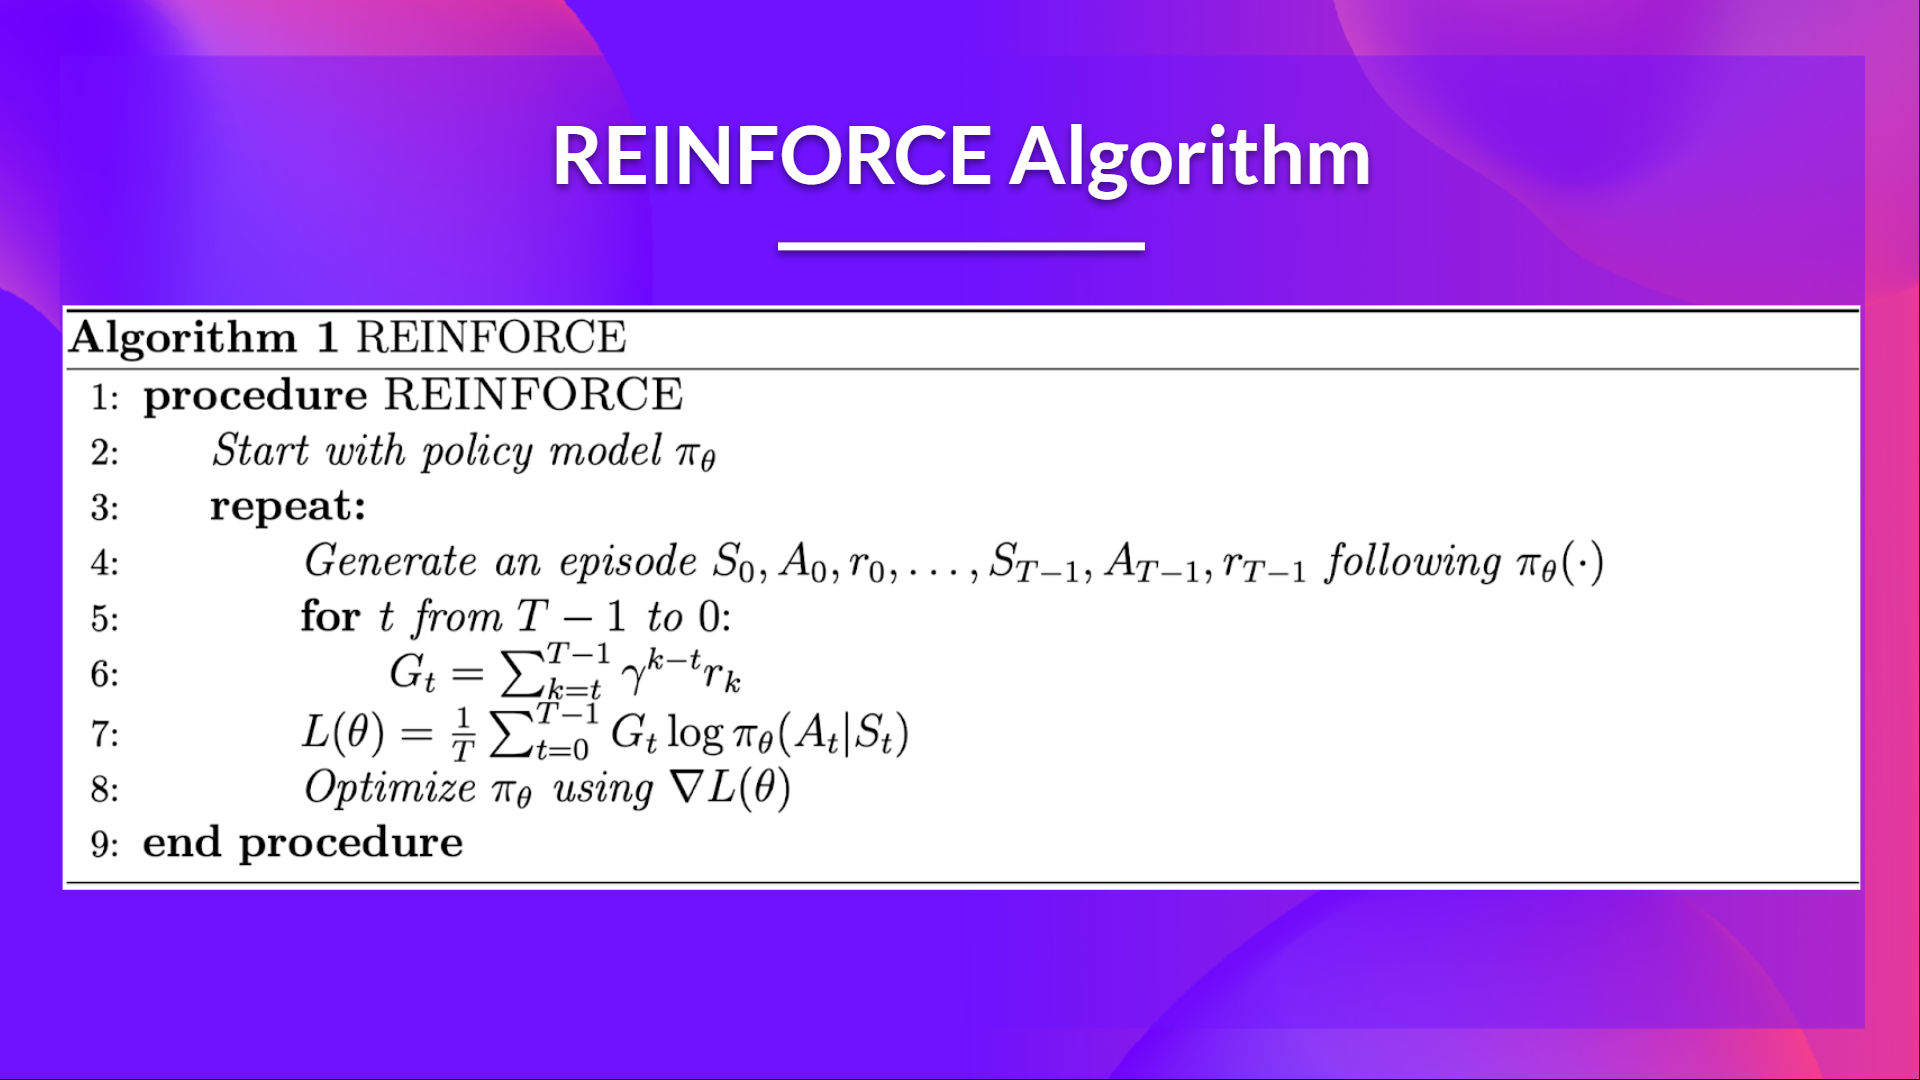

- When we calculate the return Gt we see that we calculate the sum of discounted rewards **starting at timestep t**.

- Why? Because our policy should only **reinforce actions on the basis of the consequences**: so rewards obtained before taking an action are useless (since they were not because of the action), **only the ones that come after the action matters**.

- Before coding this you should read this section [don't let the past distract you](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#don-t-let-the-past-distract-you) that explains why we use reward-to-go policy gradient.

The second question you may ask is **why do we minimize the loss**? You talked about Gradient Ascent not Gradient Descent?

- We want to maximize our utility function $J(\theta)$ but in PyTorch like in Tensorflow it's better to **minimize an objective function.**
    - So let's say we want to reinforce action 3 at a certain timestep. Before training this action P is 0.25.
    - So we want to modify $\theta$ such that $\pi_\theta(a_3|s; \theta) > 0.25$
    - Because all P must sum to 1, max $\pi_\theta(a_3|s; \theta)$ will **minimize other action probability.**
    - So we should tell PyTorch **to min $1 - \pi_\theta(a_3|s; \theta)$.**
    - This loss function approaches 0 as $\pi_\theta(a_3|s; \theta)$ nears 1.
    - So we are encouraging the gradient to max $\pi_\theta(a_3|s; \theta)$

Line 6 is an interesting technique coded by [Chris1nexus](https://github.com/Chris1nexus) to **compute the return at each timestep efficiently**. The comments explained the procedure. Don't hesitate also [to check the PR explanation](https://github.com/huggingface/deep-rl-class/pull/95)
But overall the idea is to **compute the return at each timestep efficiently**.

In [ ]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state = # TODO: reset the environment
        # Line 4 of pseudocode
        for t in range(max_t):
            action, log_prob = # TODO get the action
            saved_log_probs.append(log_prob)
            state, reward, done, _ = # TODO: take an env step
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t) 
        n_steps = len(rewards) 
        # Compute the discounted returns at each timestep,
        # as the sum of the gamma-discounted return at time t (G_t) + the reward at time t
        
        # In O(N) time, where N is the number of time steps
        # (this definition of the discounted return G_t follows the definition of this quantity 
        # shown at page 44 of Sutton&Barto 2017 2nd draft)
        # G_t = r_(t+1) + r_(t+2) + ...
        
        # Given this formulation, the returns at each timestep t can be computed 
        # by re-using the computed future returns G_(t+1) to compute the current return G_t
        # G_t = r_(t+1) + gamma*G_(t+1)
        # G_(t-1) = r_t + gamma* G_t
        # (this follows a dynamic programming approach, with which we memorize solutions in order 
        # to avoid computing them multiple times)
        
        # This is correct since the above is equivalent to (see also page 46 of Sutton&Barto 2017 2nd draft)
        # G_(t-1) = r_t + gamma*r_(t+1) + gamma*gamma*r_(t+2) + ...
        
        
        ## Given the above, we calculate the returns at timestep t as: 
        #               gamma[t] * return[t] + reward[t]
        #
        ## We compute this starting from the last timestep to the first, in order
        ## to employ the formula presented above and avoid redundant computations that would be needed 
        ## if we were to do it from first to last.
        
        ## Hence, the queue "returns" will hold the returns in chronological order, from t=0 to t=n_steps
        ## thanks to the appendleft() function which allows to append to the position 0 in constant time O(1)
        ## a normal python list would instead require O(N) to do this.
        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft(    ) # TODO: complete here        
       
        ## standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()
        
        ## eps is the smallest representable float, which is 
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)
        
        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()
        
        # Line 8: PyTorch prefers gradient descent 
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
    return scores

#### Solution

In [ ]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Line 4 of pseudocode
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t) 
        n_steps = len(rewards) 
        # Compute the discounted returns at each timestep,
        # as 
        #      the sum of the gamma-discounted return at time t (G_t) + the reward at time t
        #
        # In O(N) time, where N is the number of time steps
        # (this definition of the discounted return G_t follows the definition of this quantity 
        # shown at page 44 of Sutton&Barto 2017 2nd draft)
        # G_t = r_(t+1) + r_(t+2) + ...
        
        # Given this formulation, the returns at each timestep t can be computed 
        # by re-using the computed future returns G_(t+1) to compute the current return G_t
        # G_t = r_(t+1) + gamma*G_(t+1)
        # G_(t-1) = r_t + gamma* G_t
        # (this follows a dynamic programming approach, with which we memorize solutions in order 
        # to avoid computing them multiple times)
        
        # This is correct since the above is equivalent to (see also page 46 of Sutton&Barto 2017 2nd draft)
        # G_(t-1) = r_t + gamma*r_(t+1) + gamma*gamma*r_(t+2) + ...
        
        
        ## Given the above, we calculate the returns at timestep t as: 
        #               gamma[t] * return[t] + reward[t]
        #
        ## We compute this starting from the last timestep to the first, in order
        ## to employ the formula presented above and avoid redundant computations that would be needed 
        ## if we were to do it from first to last.
        
        ## Hence, the queue "returns" will hold the returns in chronological order, from t=0 to t=n_steps
        ## thanks to the appendleft() function which allows to append to the position 0 in constant time O(1)
        ## a normal python list would instead require O(N) to do this.
        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft( gamma*disc_return_t + rewards[t]   )    
            
        ## standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is 
        # added to the standard deviation of the returns to avoid numerical instabilities        
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)
        
        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()
        
        # Line 8: PyTorch prefers gradient descent 
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
    return scores

##  Train it
- We're now ready to train our agent.
- But first, we define a variable containing all the training hyperparameters.
- You can change the training parameters (and should 😉)

In [ ]:
cartpole_hyperparameters = {
    "h_size": 16,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [ ]:
# Create policy and place it to the device
cartpole_policy = Policy(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["action_space"], cartpole_hyperparameters["h_size"]).to(device)
cartpole_optimizer = optim.Adam(cartpole_policy.parameters(), lr=cartpole_hyperparameters["lr"])

In [ ]:
scores = reinforce(cartpole_policy,
                   cartpole_optimizer,
                   cartpole_hyperparameters["n_training_episodes"], 
                   cartpole_hyperparameters["max_t"],
                   cartpole_hyperparameters["gamma"], 
                   100)

## Define evaluation method 📝
- Here we define the evaluation method that we're going to use to test our Reinforce agent.

In [ ]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
    
    for step in range(max_steps):
      action, _ = policy.act(state)
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward
        
      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

## Evaluate our agent 📈

In [ ]:
evaluate_agent(eval_env, 
               cartpole_hyperparameters["max_t"], 
               cartpole_hyperparameters["n_evaluation_episodes"],
               cartpole_policy)

## Publish our trained model on the Hub 🔥
Now that we saw we got good results after the training, we can publish our trained model on the hub 🤗 with one line of code.

Here's an example of a Model Card:

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/modelcard.png"/>

### Push to the Hub
#### Do not modify this code

In [ ]:
from huggingface_hub import HfApi, snapshot_download
from huggingface_hub.repocard import metadata_eval_result, metadata_save

from pathlib import Path
import datetime
import json
import imageio

import os

In [ ]:
def record_video(env, policy, out_directory, fps=30):
  """
  Generate a replay video of the agent
  :param env
  :param Qtable: Qtable of our agent
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """
  images = []  
  done = False
  state = env.reset()
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action, _ = policy.act(state)
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [ ]:
def push_to_hub(repo_id, 
                model,
                hyperparameters,
                eval_env,
                video_fps=30,
                local_repo_path="hub"
                ):
  """
  Evaluate, Generate a video and Upload a model to Hugging Face Hub.
  This method does the complete pipeline:
  - It evaluates the model
  - It generates the model card
  - It generates a replay video of the agent
  - It pushes everything to the Hub

  :param repo_id: repo_id: id of the model repository from the Hugging Face Hub
  :param model: the pytorch model we want to save
  :param hyperparameters: training hyperparameters
  :param eval_env: evaluation environment
  :param video_fps: how many frame per seconds to record our video replay 
  :param local_repo_path: where the local repository is
  """

  _, repo_name = repo_id.split("/")
  api = HfApi()
  
  # Step 1: Create the repo
  repo_url = api.create_repo(
        repo_id=repo_id,
        exist_ok=True,
  )

  # Step 2: Download files
  repo_local_path = Path(snapshot_download(repo_id=repo_id))

  # Step 3: Save the model
  torch.save(model, os.path.join(repo_local_path,"model.pt"))

  # Step 4: Save the hyperparameters to JSON
  with open(Path(repo_local_path) / "hyperparameters.json", "w") as outfile:
    json.dump(hyperparameters, outfile)
  
  # Step 5: Evaluate the model and build JSON
  mean_reward, std_reward = evaluate_agent(eval_env, 
                                           hyperparameters["max_t"],
                                           hyperparameters["n_evaluation_episodes"], 
                                           model)
  # Get datetime
  eval_datetime = datetime.datetime.now()
  eval_form_datetime = eval_datetime.isoformat()

  evaluate_data = {
        "env_id": hyperparameters["env_id"], 
        "mean_reward": mean_reward,
        "n_evaluation_episodes": hyperparameters["n_evaluation_episodes"],
        "eval_datetime": eval_form_datetime,
  }

  # Write a JSON file
  with open(Path(repo_local_path) / "results.json", "w") as outfile:
      json.dump(evaluate_data, outfile)

  # Step 6: Create the model card
  # Env id
  env_name = hyperparameters["env_id"]
  
  metadata = {}
  metadata["tags"] = [
        env_name,
        "reinforce",
        "reinforcement-learning",
        "custom-implementation",
        "deep-rl-class"
    ]

  # Add metrics
  eval = metadata_eval_result(
      model_pretty_name=repo_name,
      task_pretty_name="reinforcement-learning",
      task_id="reinforcement-learning",
      metrics_pretty_name="mean_reward",
      metrics_id="mean_reward",
      metrics_value=f"{mean_reward:.2f} +/- {std_reward:.2f}",
      dataset_pretty_name=env_name,
      dataset_id=env_name,
    )

  # Merges both dictionaries
  metadata = {**metadata, **eval}

  model_card = f"""
  # **Reinforce** Agent playing **{env_id}**
  This is a trained model of a **Reinforce** agent playing **{env_id}** .
  To learn to use this model and train yours check Unit 4 of the Deep Reinforcement Learning Course: https://huggingface.co/deep-rl-course/unit4/introduction
  """

  readme_path = repo_local_path / "README.md"
  readme = ""
  if readme_path.exists():
      with readme_path.open("r", encoding="utf8") as f:
        readme = f.read()
  else:
    readme = model_card

  with readme_path.open("w", encoding="utf-8") as f:
    f.write(readme)

  # Save our metrics to Readme metadata
  metadata_save(readme_path, metadata)

  # Step 7: Record a video
  video_path =  repo_local_path / "replay.mp4"
  record_video(env, model, video_path, video_fps)

  # Step 7. Push everything to the Hub
  api.upload_folder(
        repo_id=repo_id,
        folder_path=repo_local_path,
        path_in_repo=".",
  )

  print(f"Your model is pushed to the hub. You can view your model here: {repo_url}")

### .

By using `push_to_hub` **you evaluate, record a replay, generate a model card of your agent and push it to the Hub**.

This way:
- You can **showcase our work** 🔥
- You can **visualize your agent playing** 👀
- You can **share with the community an agent that others can use** 💾
- You can **access a leaderboard 🏆 to see how well your agent is performing compared to your classmates** 👉 https://huggingface.co/spaces/huggingface-projects/Deep-Reinforcement-Learning-Leaderboard


To be able to share your model with the community there are three more steps to follow:

1️⃣ (If it's not already done) create an account to HF ➡ https://huggingface.co/join

2️⃣ Sign in and then, you need to store your authentication token from the Hugging Face website.
- Create a new token (https://huggingface.co/settings/tokens) **with write role**


<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/create-token.jpg" alt="Create HF Token">


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

If you don't want to use a Google Colab or a Jupyter Notebook, you need to use this command instead: `huggingface-cli login` (or `login`)

3️⃣ We're now ready to push our trained agent to the 🤗 Hub 🔥 using `package_to_hub()` function

In [ ]:
repo_id = "" #TODO Define your repo id {username/Reinforce-{model-id}}
push_to_hub(repo_id,
                cartpole_policy, # The model we want to save
                cartpole_hyperparameters, # Hyperparameters
                eval_env, # Evaluation environment
                video_fps=30,
                local_repo_path="hub",
                )

Now that we try the robustness of our implementation, let's try with more complex environments with PixelCopter 🚁




## Second agent: PixelCopter 🚁

### Step 1: Study the PixelCopter environment 👀
- [The Environment documentation](https://pygame-learning-environment.readthedocs.io/en/latest/user/games/pixelcopter.html)


In [ ]:
env_id = "Pixelcopter-PLE-v0"
env = gym.make(env_id)
eval_env = gym.make(env_id)
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

In [ ]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action

The observation space (7) 👀:
- player y position
- player velocity
- player distance to floor
- player distance to ceiling
- next block x distance to player
- next blocks top y location
- next blocks bottom y location

The action space(2) 🎮:
- Up
- Down

The reward function 💰: 
- For each vertical block it passes through it gains a positive reward of +1. Each time a terminal state reached it receives a negative reward of -1.

### Step 2: Define the hyperparameters ⚙️
- Because this environment is more complex, we need to change the hyperparameters
- Especially the hidden size, we need more neurons.

In [ ]:
pixelcopter_hyperparameters = {
    "h_size": 64,
    "n_training_episodes": 50000,
    "n_evaluation_episodes": 10,
    "max_t": 10000,
    "gamma": 0.99,
    "lr": 1e-4,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [ ]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, h_size*2)
        self.fc3 = nn.Linear(h_size*2, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [ ]:
# Create policy and place it to the device
# torch.manual_seed(50)
pixelcopter_policy = Policy(pixelcopter_hyperparameters["state_space"], pixelcopter_hyperparameters["action_space"], pixelcopter_hyperparameters["h_size"]).to(device)
pixelcopter_optimizer = optim.Adam(pixelcopter_policy.parameters(), lr=pixelcopter_hyperparameters["lr"])

In [ ]:
scores = reinforce(pixelcopter_policy,
                   pixelcopter_optimizer,
                   pixelcopter_hyperparameters["n_training_episodes"], 
                   pixelcopter_hyperparameters["max_t"],
                   pixelcopter_hyperparameters["gamma"], 
                   1000)

In [ ]:
repo_id = "ThomasSimonini/Secondtestpx" #TODO Define your repo id {username/Reinforce-{model-id}}
push_to_hub(repo_id,
                pixelcopter_policy, # The model we want to save
                pixelcopter_hyperparameters, # Hyperparameters
                eval_env, # Evaluation environment
                video_fps=30,
                local_repo_path="hub",
                )


## Some additional challenges 🏆
The best way to learn **is to try things by your own**! As you saw, the current agent is not doing great. As a first suggestion, you can train for more steps. But also trying to find better parameters.

In the [Leaderboard](https://huggingface.co/spaces/huggingface-projects/Deep-Reinforcement-Learning-Leaderboard) you will find your agents. Can you get to the top?

Here are some ideas to achieve so:
* Train more steps
* Try different hyperparameters by looking at what your classmates have done 👉 https://huggingface.co/models?other=reinforce
* **Push your new trained model** on the Hub 🔥
* **Improving the implementation for more complex environments** (for instance, what about changing the network to a Convolutional Neural Network to handle
frames as observation)?

________________________________________________________________________

**Congrats on finishing this unit**! There was a lot of information.
And congrats on finishing the tutorial. You've just coded your first Deep Reinforcement Learning agent from scratch using PyTorch and shared it on the Hub 🥳.

Don't hesitate to iterate on this unit **by improving the implementation for more complex environments** (for instance, what about changing the network to a Convolutional Neural Network to handle
frames as observation)?

In the next unit, **we're going to learn more about Unity MLAgents**, by training agents in Unity environments. This way, you will be ready to participate in the **AI vs AI challenges where you'll train your agents
to compete against other agents in a snowball fight and a soccer game.**

Sounds fun? See you next time!

Finally, we would love **to hear what you think of the course and how we can improve it**. If you have some feedback then, please 👉  [fill this form](https://forms.gle/BzKXWzLAGZESGNaE9)

See you on Unit 5! 🔥

### Keep Learning, stay awesome 🤗

